<a href="https://colab.research.google.com/github/teoad95/Deep-learning-Cryptocurrency-price-prediction/blob/main/Etherium_prediction_thodoris.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import numpy as np

In [2]:
pwd

'/content'

In [3]:
# get market info for bitcoin from the start of 2016 to the current day

eth_market_info = pd.read_csv('EthereumDataset.csv')
eth_market_info.index

RangeIndex(start=0, stop=2088, step=1)

In [4]:
eth_market_info = eth_market_info.dropna(how='any',axis=0) 
eth_market_info['Date'] = pd.to_datetime(eth_market_info['Date'])


In [5]:
# convert the date string to the correct date format
#eth_market_info = eth_market_info.assign(Date=pd.to_datetime(eth_market_info['Date']))
# when Volume is equal to '-' convert it to 0
eth_market_info.loc[eth_market_info['Volume']=="-",'Volume']=0
# sometime after publication of the blog, coinmarketcap starting returning asterisks in the column names
# this will remove those asterisks
eth_market_info.columns = eth_market_info.columns.str.replace("*", "")

In [6]:
eth_market_info['Date']

0      2015-08-07
1      2015-08-08
2      2015-08-09
3      2015-08-10
4      2015-08-11
          ...    
2083   2021-04-20
2084   2021-04-21
2085   2021-04-22
2086   2021-04-23
2087   2021-04-24
Name: Date, Length: 2084, dtype: datetime64[ns]

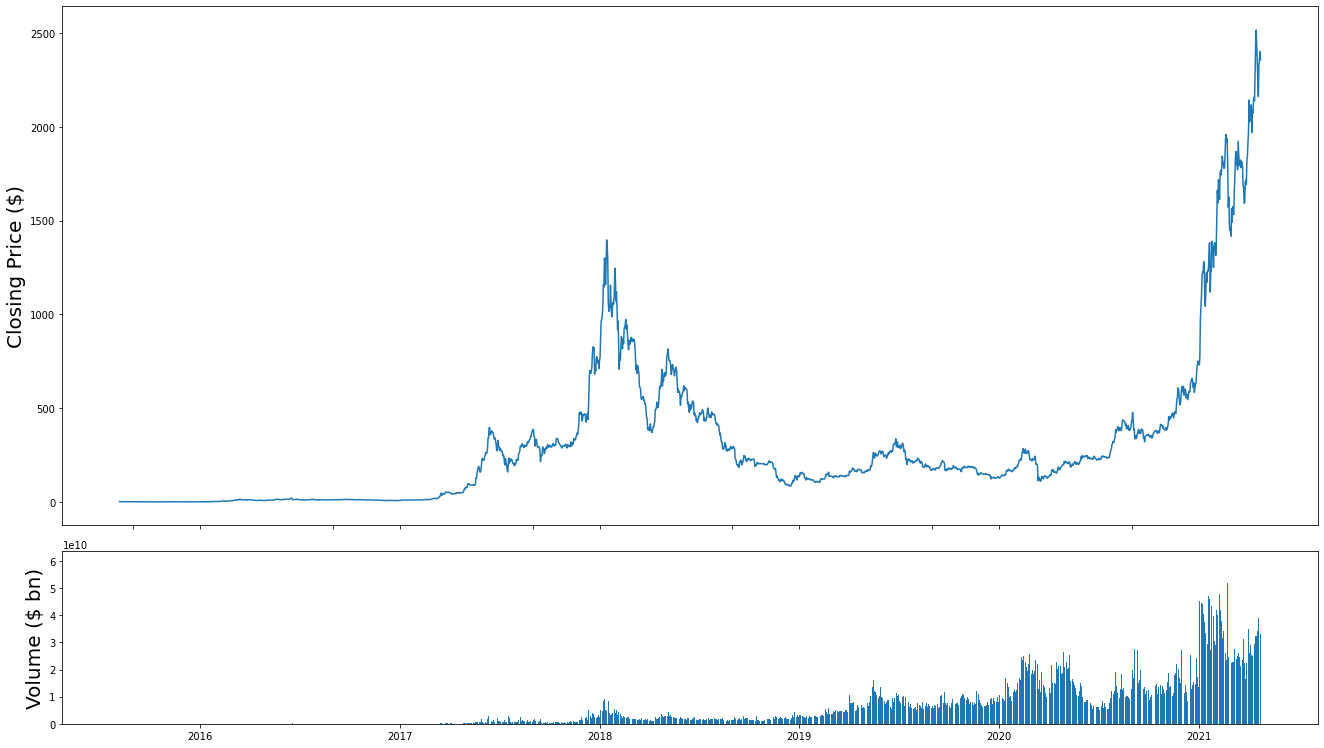

In [7]:
fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[3, 1]})
#ax1.set_yscale('log')
ax1.set_ylabel('Closing Price ($)',fontsize=20)
ax2.set_ylabel('Volume ($ bn)',fontsize=20)
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2021) for j in [1,9]])
ax1.set_xticklabels('')
ax1.plot(eth_market_info['Date'],eth_market_info['Open'])
ax2.bar(eth_market_info['Date'], eth_market_info['Volume'].values)
fig.set_size_inches(18.5, 10.5)
fig.tight_layout()

plt.show()

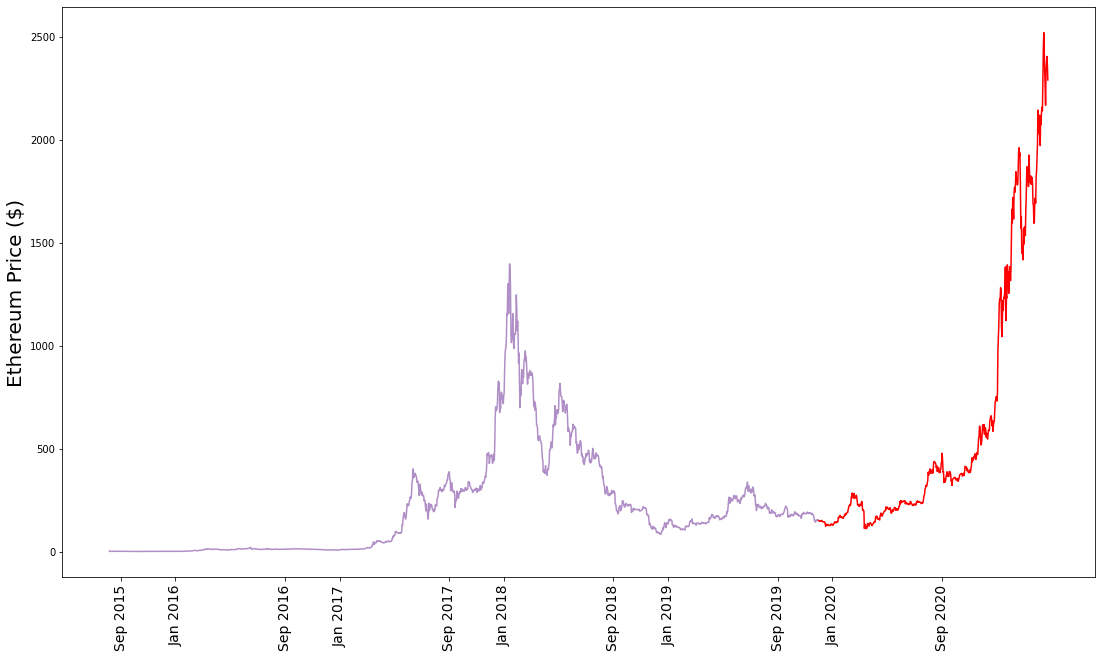

In [8]:
split_date = '2019-12-01'
fig, (ax2) = plt.subplots(1,1)
ax2.set_xticks([datetime.date(i,j,1) for i in range(2013,2021) for j in [1,9]])
ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2021) for j in [1,9]])
ax2.plot(eth_market_info[eth_market_info['Date'] < split_date]['Date'],
         eth_market_info[eth_market_info['Date'] < split_date]['Close'], 
         color='#B08FC7')
ax2.plot(eth_market_info[eth_market_info['Date'] >= split_date]['Date'],
         eth_market_info[eth_market_info['Date'] >= split_date]['Close'], color='red')
ax2.set_ylabel('Ethereum Price ($)',fontsize=20)
fig.set_size_inches(18.5, 10.5)
plt.xticks(fontsize=14, rotation=90)
plt.show()

In [9]:
kwargs = {'close_off_high': lambda x: 2*(x['High']- x['Close'])/(x['High']-x['Low'])-1,
          'volatility': lambda x: (x['High']- x['Low'])/(x['Open'])}
eth_market_info = eth_market_info.assign(**kwargs)
eth_market_info = eth_market_info.drop('Open', 1)
eth_market_info = eth_market_info.drop('High', 1)
eth_market_info = eth_market_info.drop('Low', 1)
eth_market_info = eth_market_info.drop('Adj Close', 1)

In [10]:
model_data = eth_market_info.sort_values(by='Date')
# we don't need the date columns anymore
training_set, test_set = model_data[model_data['Date']<split_date], model_data[model_data['Date']>=split_date]
training_set = training_set.drop('Date', 1)
test_set = test_set.drop('Date', 1)

In [11]:
window_len = 10

In [12]:
LSTM_training_inputs = []
for i in range(len(training_set)-window_len):
    temp_set = training_set[i:(i+window_len)].copy()
    for col in ['Close','Volume']:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_training_inputs.append(temp_set)
LSTM_training_outputs = (training_set['Close'][window_len:].values/training_set['Close'][:-window_len].values)-1

In [13]:
LSTM_test_inputs = []
for i in range(len(test_set)-window_len):
    temp_set = test_set[i:(i+window_len)].copy()
    for col in ['Close','Volume']:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_test_inputs.append(temp_set)
LSTM_test_outputs = (test_set['Close'][window_len:].values/test_set['Close'][:-window_len].values)-1

In [14]:
LSTM_training_inputs[0]

,Close,Volume,close_off_high,volatility
0,0.000000,0.000000,0.505657,0.358625
1,-0.728249,3.102672,0.962957,0.745979
2,-0.746801,2.238442,0.419789,0.354916
3,-0.744438,1.466290,-0.541175,0.130685
4,-0.614786,7.903480,-0.728520,0.661183
5,-0.560827,12.087282,-0.643149,0.383785
6,-0.340696,23.759355,-0.653503,0.648874
7,-0.340624,27.217965,0.711632,0.280040
8,-0.390755,14.544183,0.229935,0.169872
9,-0.435079,20.607811,-0.573163,0.359444


In [15]:
# I find it easier to work with numpy arrays rather than pandas dataframes
# especially as we now only have numerical data
LSTM_training_inputs = [np.array(LSTM_training_input) for LSTM_training_input in LSTM_training_inputs]
LSTM_training_inputs = np.array(LSTM_training_inputs)

LSTM_test_inputs = [np.array(LSTM_test_inputs) for LSTM_test_inputs in LSTM_test_inputs]
LSTM_test_inputs = np.array(LSTM_test_inputs)

In [16]:
# import the relevant Keras modules
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout

def build_model(inputs, output_size, neurons, activ_func="linear",
                dropout=0.25, loss="mae", optimizer="adam"):
    model = Sequential()
    
    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [17]:
# random seed for reproducibility
np.random.seed(202)
# initialise model architecture
eth_model = build_model(LSTM_training_inputs, output_size=1, neurons = 20)
# model output is next price normalised to 10th previous closing price
LSTM_training_outputs = (training_set['Close'][window_len:].values/training_set['Close'][:-window_len].values)-1
# train model on data
# note: eth_history contains information on the training error per epoch
eth_history = eth_model.fit(LSTM_training_inputs, LSTM_training_outputs, 
                            epochs=50, batch_size=1, verbose=2, shuffle=True)

Epoch 1/50
1567/1567 - 6s - loss: 0.0821
Epoch 2/50
1567/1567 - 4s - loss: 0.0649
Epoch 3/50
1567/1567 - 4s - loss: 0.0590
Epoch 4/50
1567/1567 - 4s - loss: 0.0575
Epoch 5/50
1567/1567 - 4s - loss: 0.0549
Epoch 6/50
1567/1567 - 4s - loss: 0.0552
Epoch 7/50
1567/1567 - 4s - loss: 0.0555
Epoch 8/50
1567/1567 - 4s - loss: 0.0550
Epoch 9/50
1567/1567 - 4s - loss: 0.0536
Epoch 10/50
1567/1567 - 4s - loss: 0.0538
Epoch 11/50
1567/1567 - 4s - loss: 0.0539
Epoch 12/50
1567/1567 - 4s - loss: 0.0537
Epoch 13/50
1567/1567 - 4s - loss: 0.0540
Epoch 14/50
1567/1567 - 4s - loss: 0.0542
Epoch 15/50
1567/1567 - 4s - loss: 0.0530
Epoch 16/50
1567/1567 - 4s - loss: 0.0519
Epoch 17/50
1567/1567 - 4s - loss: 0.0534
Epoch 18/50
1567/1567 - 4s - loss: 0.0529
Epoch 19/50
1567/1567 - 4s - loss: 0.0537
Epoch 20/50
1567/1567 - 4s - loss: 0.0516
Epoch 21/50
1567/1567 - 4s - loss: 0.0535
Epoch 22/50
1567/1567 - 4s - loss: 0.0533
Epoch 23/50
1567/1567 - 4s - loss: 0.0512
Epoch 24/50
1567/1567 - 4s - loss: 0.0528
E

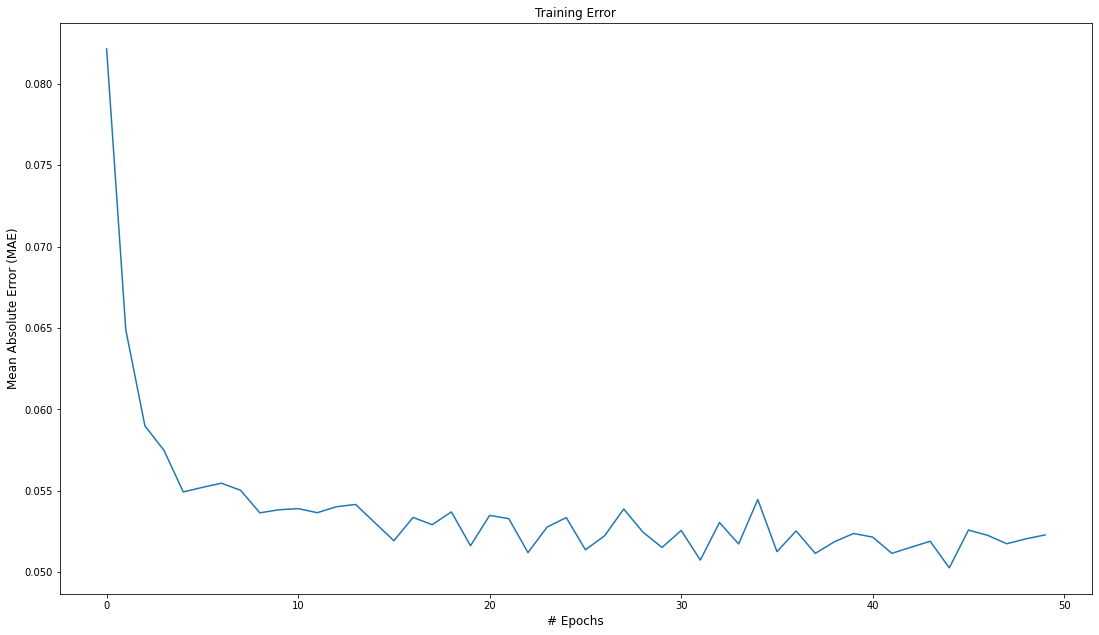

In [18]:
fig, ax1 = plt.subplots(1,1)

ax1.plot(eth_history.epoch, eth_history.history['loss'])
ax1.set_title('Training Error')

if eth_model.loss == 'mae':
    ax1.set_ylabel('Mean Absolute Error (MAE)',fontsize=12)
# just in case you decided to change the model loss calculation
else:
    ax1.set_ylabel('Model Loss',fontsize=12)
ax1.set_xlabel('# Epochs',fontsize=12)
fig.set_size_inches(18.5, 10.5)
plt.show()

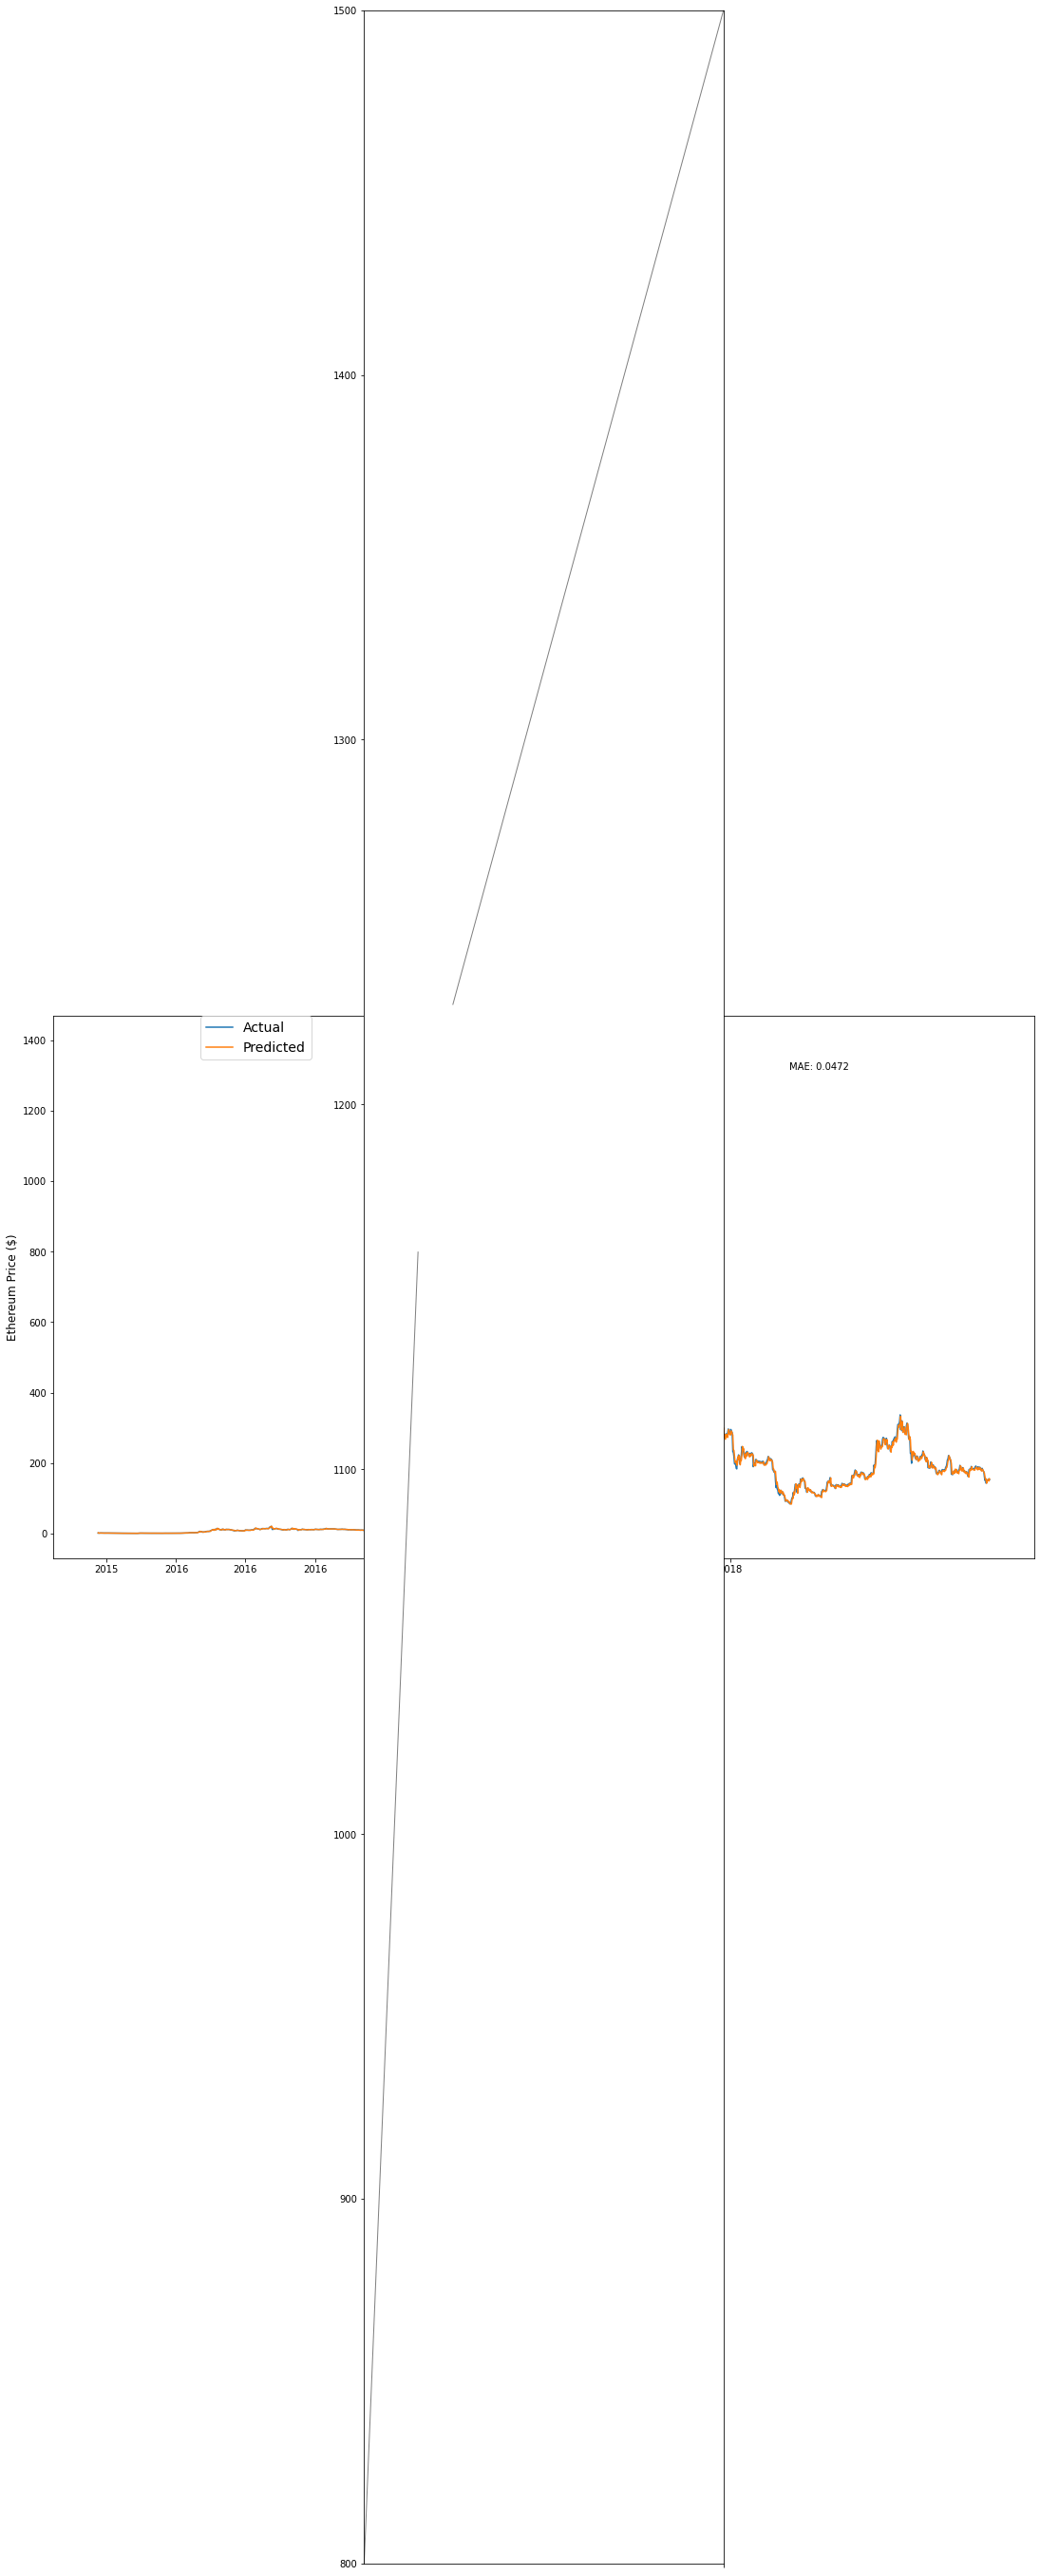

In [19]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

fig, ax1 = plt.subplots(1,1)
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,5,9]])
#ax1.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2021) for j in [1,5,9]])
ax1.plot(model_data[model_data['Date']< split_date]['Date'][window_len:],
         training_set['Close'][window_len:], label='Actual')
ax1.plot(model_data[model_data['Date']< split_date]['Date'][window_len:],
         ((np.transpose(eth_model.predict(LSTM_training_inputs))+1) * training_set['Close'].values[:-window_len])[0], 
         label='Predicted')
ax1.set_title('Training Set: Single Timepoint Prediction')
ax1.set_ylabel('Ethereum Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.15, 1), loc=2, borderaxespad=0., prop={'size': 14})
ax1.annotate('MAE: %.4f'%np.mean(np.abs((np.transpose(eth_model.predict(LSTM_training_inputs))+1)-\
            (training_set['Close'].values[window_len:])/(training_set['Close'].values[:-window_len]))), 
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.75, 0.9), textcoords='axes fraction')
# figure inset code taken from http://akuederle.com/matplotlib-zoomed-up-inset
axins = zoomed_inset_axes(ax1, 10.35, loc=10) # zoom-factor: 3.35, location: centre
axins.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,5,9]])
axins.plot(model_data[model_data['Date']< split_date]['Date'][window_len:],
         training_set['Close'][window_len:], label='Actual')
axins.plot(model_data[model_data['Date']< split_date]['Date'][window_len:],
         ((np.transpose(eth_model.predict(LSTM_training_inputs))+1) * training_set['Close'].values[:-window_len])[0], 
         label='Predicted')
axins.set_xlim([datetime.date(2017, 3, 1), datetime.date(2017, 5, 1)])
axins.set_ylim([800,1500])
axins.set_xticklabels('')
mark_inset(ax1, axins, loc1=1, loc2=3, fc="none", ec="0.5")
fig.set_size_inches(18.5, 10.5)
plt.show()


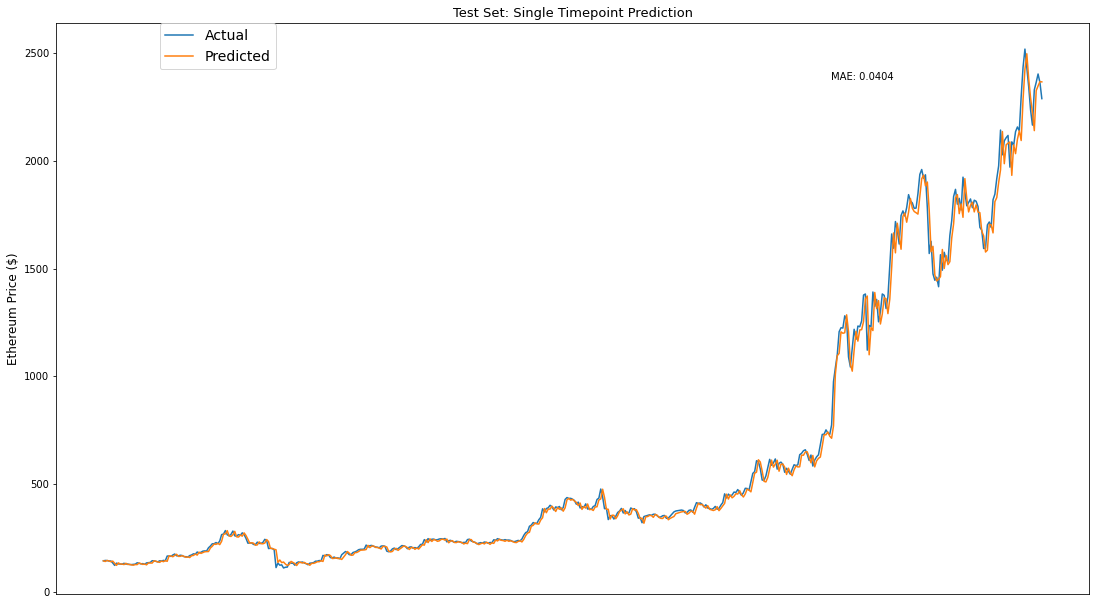

In [20]:
fig, ax1 = plt.subplots(1,1)
ax1.set_xticks([datetime.date(2017,i+1,1) for i in range(12)])
ax1.set_xticklabels([datetime.date(2017,i+1,1).strftime('%b %d %Y')  for i in range(12)])
ax1.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:],
         test_set['Close'][window_len:], label='Actual')
ax1.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:],
         ((np.transpose(eth_model.predict(LSTM_test_inputs))+1) * test_set['Close'].values[:-window_len])[0], 
         label='Predicted')
ax1.annotate('MAE: %.4f'%np.mean(np.abs((np.transpose(eth_model.predict(LSTM_test_inputs))+1)-\
            (test_set['Close'].values[window_len:])/(test_set['Close'].values[:-window_len]))), 
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.75, 0.9), textcoords='axes fraction')
ax1.set_title('Test Set: Single Timepoint Prediction',fontsize=13)
ax1.set_ylabel('Ethereum Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., prop={'size': 14})
fig.set_size_inches(18.5, 10.5)
plt.show()

In [21]:
# random seed for reproducibility
np.random.seed(202)
# we'll try to predict the closing price for the next 5 days 
# change this value if you want to make longer/shorter prediction
pred_range = 50
# initialise model architecture
eth_model = build_model(LSTM_training_inputs, output_size=pred_range, neurons = 20)
# model output is next 5 prices normalised to 10th previous closing price
LSTM_training_outputs = []
for i in range(window_len, len(training_set['Close'])-pred_range):
    LSTM_training_outputs.append((training_set['Close'][i:i+pred_range].values/
                                  training_set['Close'].values[i-window_len])-1)
LSTM_training_outputs = np.array(LSTM_training_outputs)
# train model on data
# note: eth_history contains information on the training error per epoch
eth_history = eth_model.fit(LSTM_training_inputs[:-pred_range], LSTM_training_outputs, 
                            epochs=50, batch_size=1, verbose=2, shuffle=True)

Epoch 1/50
1517/1517 - 5s - loss: 0.4444
Epoch 2/50
1517/1517 - 4s - loss: 0.4189
Epoch 3/50
1517/1517 - 3s - loss: 0.4142
Epoch 4/50
1517/1517 - 4s - loss: 0.4121
Epoch 5/50
1517/1517 - 4s - loss: 0.4111
Epoch 6/50
1517/1517 - 4s - loss: 0.4104
Epoch 7/50
1517/1517 - 4s - loss: 0.4065
Epoch 8/50
1517/1517 - 4s - loss: 0.4056
Epoch 9/50
1517/1517 - 4s - loss: 0.4032
Epoch 10/50
1517/1517 - 4s - loss: 0.4025
Epoch 11/50
1517/1517 - 4s - loss: 0.4006
Epoch 12/50
1517/1517 - 4s - loss: 0.3971
Epoch 13/50
1517/1517 - 4s - loss: 0.3974
Epoch 14/50
1517/1517 - 4s - loss: 0.3962
Epoch 15/50
1517/1517 - 4s - loss: 0.3968
Epoch 16/50
1517/1517 - 4s - loss: 0.3941
Epoch 17/50
1517/1517 - 3s - loss: 0.3954
Epoch 18/50
1517/1517 - 3s - loss: 0.3848
Epoch 19/50
1517/1517 - 4s - loss: 0.3874
Epoch 20/50
1517/1517 - 4s - loss: 0.3858
Epoch 21/50
1517/1517 - 4s - loss: 0.3850
Epoch 22/50
1517/1517 - 4s - loss: 0.3830
Epoch 23/50
1517/1517 - 4s - loss: 0.3814
Epoch 24/50
1517/1517 - 4s - loss: 0.3752
E

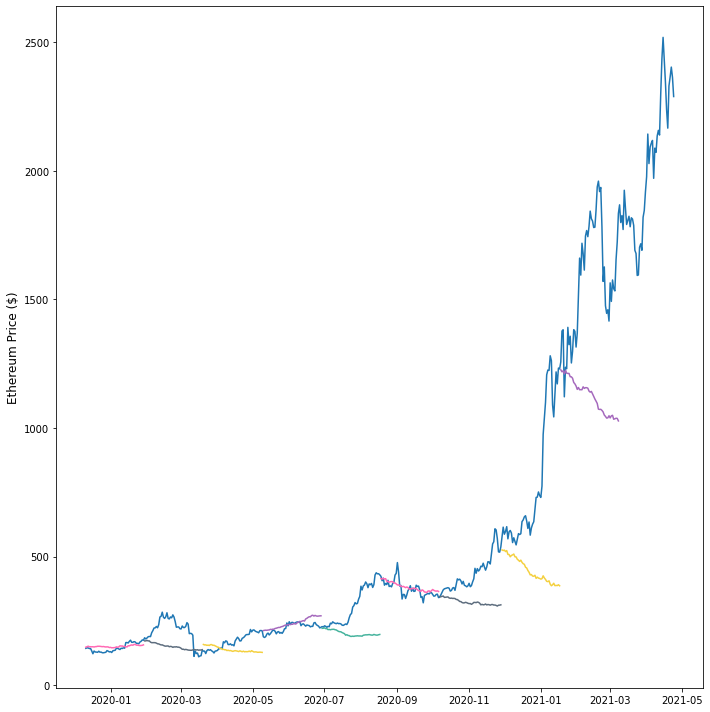

In [22]:
# little bit of reformatting the predictions to closing prices
eth_pred_prices = ((eth_model.predict(LSTM_test_inputs)[:-pred_range][::pred_range]+1)*\
                   test_set['Close'].values[:-(window_len + pred_range)][::pred_range].reshape(int(np.ceil((len(LSTM_test_inputs)-pred_range)/float(pred_range))),1))
pred_colors = ["#FF69B4", "#5D6D7E", "#F4D03F","#A569BD","#45B39D"]
fig, (ax2) = plt.subplots(1,1, figsize=(10, 10))

#ax2.set_xticks([datetime.date(2017,i+1,1) for i in range(12)])
#ax2.set_xticklabels([datetime.date(2017,i+1,1).strftime('%b %d %Y')  for i in range(12)])
ax2.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:],
         test_set['Close'][window_len:], label='Actual')
for i, eth_pred in enumerate(eth_pred_prices):
    
    # Only adding lines to the legend once
    if i<5:
        ax2.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:][i*pred_range:((i*pred_range)+pred_range)],
                 eth_pred, color=pred_colors[i%5], label="Predicted")
    else: 
        ax2.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:][i*pred_range:i*pred_range+pred_range],
                 eth_pred, color=pred_colors[i%5])
ax2.set_ylabel('Ethereum Price ($)',fontsize=12)
fig.tight_layout()
plt.show()

In [26]:
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [27]:
# Model configuration
additional_metrics = ['accuracy']
batch_size = 128
embedding_output_dims = 15
loss_function = BinaryCrossentropy()
max_sequence_length = 300
num_distinct_words = 5000
number_of_epochs = 5
optimizer = Adam()
validation_split = 0.20
verbosity_mode = 1

In [28]:
# Disable eager execution
tf.compat.v1.disable_eager_execution()

In [29]:
# Define the Keras model
model = Sequential()
model.add(Embedding(num_distinct_words, embedding_output_dims, input_length=max_sequence_length))
model.add(LSTM(10))
model.add(Dense(1, activation='sigmoid'))

In [30]:
# Compile the model
model.compile(optimizer=optimizer, loss=loss_function, metrics=additional_metrics)

In [32]:
# Give a summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 15)           75000     
_________________________________________________________________
lstm_2 (LSTM)                (None, 10)                1040      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 76,051
Trainable params: 76,051
Non-trainable params: 0
_________________________________________________________________
